In [1]:
# Import modules
import sys,os
from shapely.geometry import box,Point,LineString
import networkx as nx
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from collections import namedtuple as nt
import pandas as pd
print("Modules imported")

Modules imported


In [2]:
# Define directories and libraries
workpath = os.getcwd()
rootpath = os.path.dirname(workpath)
libpath = rootpath + "/libs/"
inppath = rootpath + "/input/"
outpath = workpath + "/out/"
figpath = workpath + "/figs/"
sys.path.append(libpath)

# Import further necessary modules from libraries
from pyExtractDatalib import GetRoads, GetHomes
from pyBuildSecNetlib import MapLink, Link

# Get data for the test
roads = GetRoads(inppath,'121')
homes = GetHomes(inppath,'121')

## Mapping Residences to Nearest Road Link
First, we draw bounding regions around each road link and residence point. This is done such that any point in the region is within a radius $r$ from any internal point of the road network link $l$. The bounding region for link $l=(u,v)$ is
$$\mathbf{B_l}=\big\{\mathbf{p}\big|||\mathbf{p}-\mathbf{p_l}||_2\leq r,\forall \mathbf{p_l}=\theta\mathbf{p_u}+(1-\theta)\mathbf{p_v},\theta\in[0,1]\big\}\label{eq:bound-link}$$
Similarly, a bounding region is considered for a residential building $h\in\mathsf{H}$
$$\mathbf{B_h}=\big\{\mathbf{p}\big|||\mathbf{p}-\mathbf{p_h}||_2\leq r\big\}\label{eq:bound-point}$$
The intersections between the bounding region of the building/residence and those for the links are stored and indexed in a *quad-tree* data structure. This information is retrieved to identify the links (green links in the figure) which are comparably nearer to the residential building than the others. Now, the geodesic distance of point $\mathbf{p_h}$ can be computed from these short-listed links and the nearest link can be identified henceforth. This approach reduces the computational burden of evaluating the distance between all road links and residential buildings.

In [3]:
# Homes and road nodes
h = 511210211001462
nlist = [889535586, 889535587, 335455019, 171517423, 171517458, 
	171517427, 171517461, 24866230, 922394295, 24866232,171517462]

# Define a named tuple interest to store a road network subgraph of interest
interest_graph = nx.subgraph(roads.graph,nlist).copy()
interest_graph.add_edges_from([(889535586,171517461),(24866230,171517458),
                               (171517461,24866230),(24866230,889535587),
                               (24866232,335455019),(24866232,171517458)])
elist = list(interest_graph.edges())
interest_cords = {n:roads.cord[n] for n in nlist}
interest_links = {e:{'geometry':LineString((interest_cords[e[0]],
                                            interest_cords[e[1]]))} \
                  for e in elist}
interest_obj = nt("network",field_names=["graph","cord","links"])
interest = interest_obj(graph=interest_graph,cord=interest_cords,
                        links=interest_links)
xmin = min([c[0] for c in list(interest_cords.values())])-0.001
xmax = max([c[0] for c in list(interest_cords.values())])+0.001
ymin = min([c[1] for c in list(interest_cords.values())])-0.001
ymax = max([c[1] for c in list(interest_cords.values())])+0.001

In [4]:
# Define an object for the class MapLink with radius of 5e-4
M = MapLink(interest,radius=0.0005)
links = M.lines
residence = Point(homes.cord[h])
radius = 0.0003
matches = M.idx.intersect((residence.x-radius, residence.y-radius, 
                          residence.x+radius, residence.y+radius))
match_link = [l[2] for i,l in enumerate(links) if i in matches]
closest_path = min(matches, key=lambda i: M.lines[i][0].distance(residence))
nearest = M.lines[closest_path][-1]

font = 15
mark = 10


def draw_base(ax,interest,color='black'):
    nx.draw_networkx(interest.graph,pos=interest.cord,ax=ax,node_color='blue',
                 with_labels=False,node_size=50,edge_color=color,width=3)
    ax.scatter(homes.cord[h][0],homes.cord[h][1],marker='D',s=50,c='magenta')

    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='both',left=False,bottom=False,labelleft=False,labelbottom=False)

    # Update legends
    leglines = [Line2D([0], [0], color='black', markerfacecolor='blue', marker='o',
                markersize=mark,linestyle='dashed'),
                Line2D([0], [0], color='white', markerfacecolor='magenta', marker='D',
                markersize=mark)]
    labels = ['road links','residential building']
    return leglines,labels

def link_box(ax,lines,leglines,labels):
    """
    Display the bounding boxes around each road network link.
    """
    # Display bounding box for road links
    for lobj in lines:
        x1,y1,x2,y2 = lobj[1]
        b = box(x1,y1,x2,y2)
        x,y = list(b.exterior.xy)
        ax.plot(x,y,color='blue',alpha=1,linewidth=2)
    
    # Update legends and labels
    leglines += [Patch(edgecolor='blue',fill=False)]
    labels += ['bounding box for links']
    return leglines,labels

def pt_box(ax,pt,leglines,labels):
    """
    Display the bounding boxes around the residence node.
    """
    # Display the bounding box for the residential coordinate
    b = box(pt.x-radius, pt.y-radius, pt.x+radius, pt.y+radius)
    x,y = list(b.exterior.xy)
    ax.plot(x,y,color='red',alpha=1,linewidth=2)
    
    # Update legends and labels
    leglines += [Patch(edgecolor='red',fill=False)]
    labels += ['bounding box for residence']
    return leglines,labels

def match_box(ax,lines,matches,leglines,labels):
    # Display bounding box for road links
    for i,lobj in enumerate(lines):
        x1,y1,x2,y2 = lobj[1]
        b = box(x1,y1,x2,y2)
        x,y = list(b.exterior.xy)
        if i in matches:
            ax.plot(x,y,color='green',alpha=1,linewidth=2)
        else:
            ax.plot(x,y,color='blue',alpha=0.3,linewidth=2)
    
    # Update legends and labels
    leglines += [Patch(edgecolor='green',fill=False),Patch(edgecolor='blue',fill=False)]
    labels += ['bounding box for nearby links','bounding box for further links']
    return leglines,labels

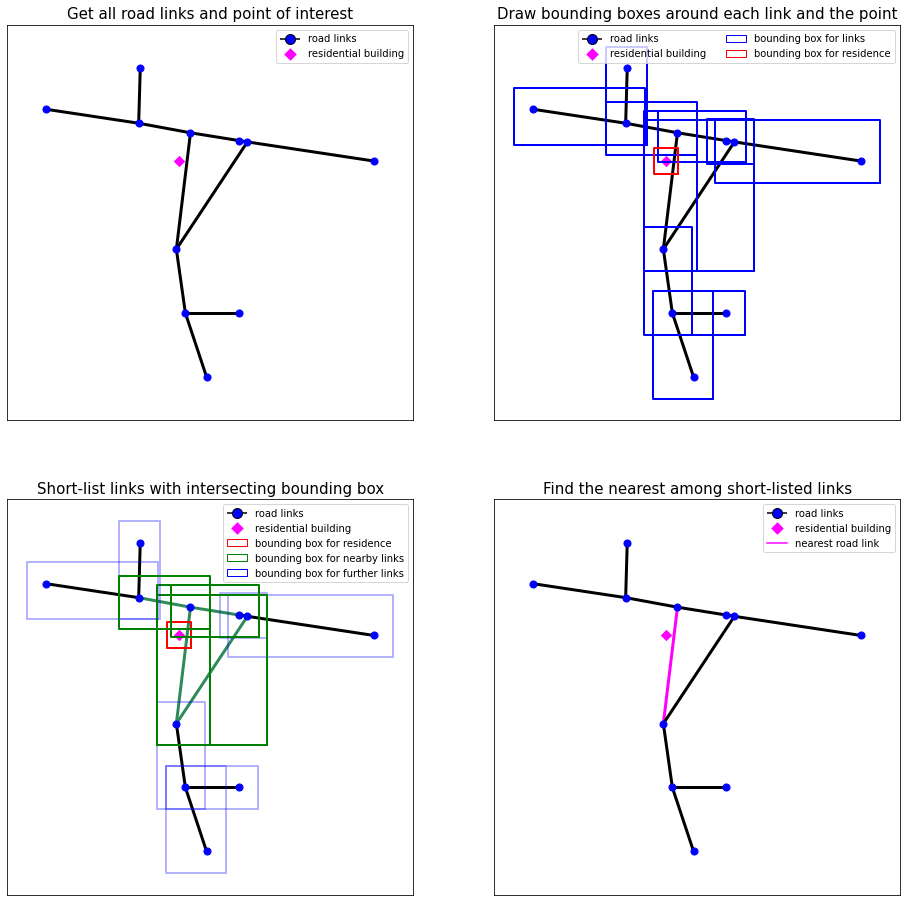

In [5]:
# Plot the steps of mapping residence to nearest link
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(221)
leglines,labels = draw_base(ax1,interest)
ax1.set_title("Get all road links and point of interest",fontsize=font)
ax1.legend(leglines,labels,loc='best',ncol=1,prop={'size': mark})

ax2 = fig.add_subplot(222)
leglines,labels = draw_base(ax2,interest)
leglines,labels = link_box(ax2,links,leglines,labels)
leglines,labels = pt_box(ax2,residence,leglines,labels)
ax2.set_title("Draw bounding boxes around each link and the point",fontsize=font)
ax2.legend(leglines,labels,loc='best',ncol=2,prop={'size': mark})

ax3 = fig.add_subplot(223)
color = ['seagreen' if e in match_link or (e[1],e[0]) in match_link else 'black' \
         for e in list(interest.graph.edges())]
leglines,labels = draw_base(ax3,interest,color)
leglines,labels = pt_box(ax3,residence,leglines,labels)
leglines,labels = match_box(ax3,links,matches,leglines,labels)
ax3.set_title("Short-list links with intersecting bounding box",fontsize=font)
ax3.legend(leglines,labels,loc='best',ncol=1,prop={'size': mark})

ax4 = fig.add_subplot(224)
color = ['magenta' if e == nearest or (e[1],e[0]) == nearest else 'black' \
         for e in list(interest.graph.edges())]
leglines,labels = draw_base(ax4,interest,color)
leglines += [Line2D([0], [0], color='magenta', markerfacecolor='blue', marker='o',
                  markersize=0)]
labels += ["nearest road link"]
ax4.set_title("Find the nearest among short-listed links",fontsize=font)
ax4.legend(leglines,labels,loc='best',ncol=1,prop={'size': mark})

fig.savefig("{}{}.png".format(figpath,'mapping-steps'),bbox_inches='tight')

## Secondary Network Generation

In [6]:
from pyBuildSecNetlib import Link, SecNet

fiscode = '121'
df_hmap = pd.read_csv(outpath+'sec-network/'+fiscode+'-home2link.csv')
H2Link = dict([(t.hid, (t.source, t.target)) for t in df_hmap.itertuples()])
with open(outpath+'sec-network/'+fiscode+'-link2home.txt','r') as f:
    linkdata = f.readlines()
dictlink = {}
for temp in linkdata:
    key = tuple([int(t) for t in temp.strip('\n').split('\t')[0].split(',')])
    value = [int(x) for x in temp.strip('\n').split('\t')[1].split(',')]
    dictlink[key]=value

link = list(dictlink.keys())[0]
homelist = dictlink[link]

secnet_obj = SecNet(homes,roads,H2Link)
forest,roots = secnet_obj.generate_optimal_topology(link,minsep=50,hops=10,
                                tsfr_max=25,heuristic=None,path=outpath)

Number of edges: 2953
Using license file C:\Users\rouna\gurobi.lic
Academic license - for non-commercial use only - expires 2021-02-11
Setting up radiality constraints
Setting up power flow constraints
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 12131 rows, 8859 columns and 36345 nonzeros
Model fingerprint: 0xc1fe8c0b
Variable types: 5906 continuous, 2953 integer (2953 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [7e-03, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 1e+02]
Presolve time: 0.03s
Presolved: 12131 rows, 8859 columns, 36345 nonzeros
Variable types: 5906 continuous, 2953 integer (2953 binary)

Root relaxation: objective 4.731417e+00, 10986 iterations, 0.11 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/No

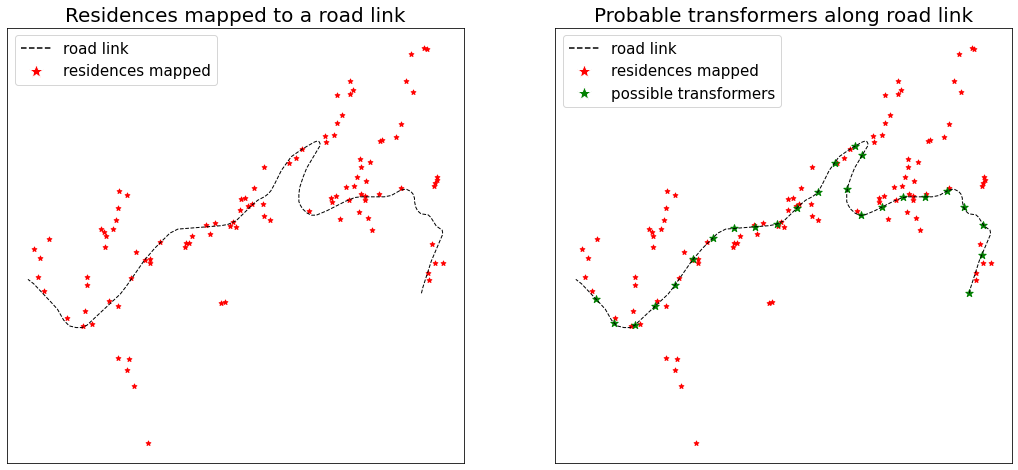

In [7]:
def display_link(link,homelist,roads,homes,path,name):
    """
    Displays the road link with the residences mapped to it. Also provides the option
    to display the probable locations of transformers along the link.

    Parameters
    ----------
    link : tuple of the terminal node IDs
        the road network link of interest.
    homelist : list of residence IDs
        list of homes mapped to the road network link.
    roads : named tuple of type road
        information related to the road network.
    homes : named tuple of type home
        information related to residences

    Returns
    -------
    None.

    """
    # Figure initialization
    fig = plt.figure(figsize=(18,8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    line = roads.links[link]['geometry'].xy if link in roads.links \
        else roads.links[(link[1],link[0])]['geometry'].xy
    link_line = Link(roads.links[link]['geometry']) if link in roads.links \
                    else Link(roads.links[(link[1],link[0])]['geometry'])
    tsfr = link_line.InterpolatePoints(50)

    # Plot the road network link with no interpolated transformer
    ax1.plot(line[0],line[1],color='black',linewidth=1,linestyle='dashed')
    ax1.scatter([homes.cord[h][0] for i,h in enumerate(homelist)],
               [homes.cord[h][1] for i,h in enumerate(homelist)],
               c='red',s=25.0,marker='*')
    ax1.set_title("Residences mapped to a road link",fontsize=20)
    leglines = [Line2D([0], [0], color='black', markerfacecolor='c', marker='*',
                       markersize=0,linestyle='dashed'),
                Line2D([0], [0], color='white', markerfacecolor='red', marker='*',
                       markersize=15)]
    labels = ['road link','residences mapped']
    ax1.legend(leglines,labels,loc='best',ncol=1,prop={'size': 15})
    
    # Plot the road network with interpolated transformers
    ax2.plot(line[0],line[1],color='black',linewidth=1,linestyle='dashed')
    ax2.scatter([homes.cord[h][0] for i,h in enumerate(homelist)],
               [homes.cord[h][1] for i,h in enumerate(homelist)],
               c='red',s=25.0,marker='*')
    ax2.scatter([t[0] for t in list(tsfr.values())],
               [t[1] for t in list(tsfr.values())],
               c='green',s=60.0,marker='*')
    leglines += [Line2D([0], [0], color='white', markerfacecolor='green', 
                        marker='*',markersize=15)]
    labels += ['possible transformers']
    ax2.set_title("Probable transformers along road link",fontsize=20)
    ax2.legend(leglines,labels,loc='best',ncol=1,prop={'size': 15})
    
    # Final adjustments
    ax1.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    ax2.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    
    # Save the figure
    fig.savefig("{}{}.png".format(path,name),bbox_inches='tight')
    return

display_link(link,homelist,roads,homes,figpath,'secnet-link-home-tsfr')

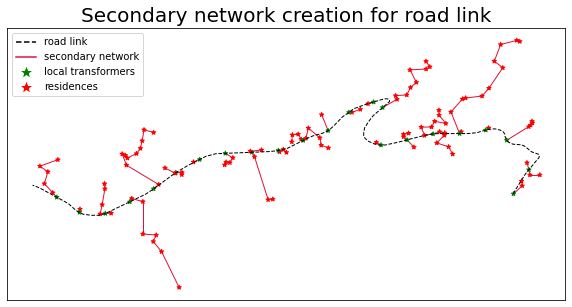

In [8]:
def display_secondary(forest,roots,link,roads,path,name):
    """
    Displays the output secondary network obtained from solving the optimization
    problem. 

    Parameters
    ----------
    forest : Networkx graph with coordinates as node attributes
        A forest of trees representing the secondary network rooted at transformers.
    roots : dictionary of transformer locations
        A dictionary with keys as transformer IDs and value as coordinates.
    link : tuple of the terminal node IDs
        the road network link of interest.
    roads : named tuple of type road
        information related to the road network.

    Returns
    -------
    None.

    """
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    
    # Plot the road network link
    line = roads.links[link]['geometry'].xy if link in roads.links \
        else roads.links[(link[1],link[0])]['geometry'].xy
    ax.plot(line[0],line[1],color='black',linewidth=1,linestyle='dashed')
    
    # Get network data
    nodelist = list(forest.nodes())
    colors = ['red' if n not in roots else 'green' for n in nodelist]
    pos_nodes = nx.get_node_attributes(forest,'cord')
    
    # Draw network
    nx.draw_networkx(forest,pos=pos_nodes,edgelist=list(forest.edges()),
                     ax=ax,edge_color='crimson',width=1,with_labels=False,
                     node_size=20.0,node_shape='*',node_color=colors)
    
    # Other updates
    leglines = [Line2D([0], [0], color='black', markerfacecolor='green', marker='*',
                       markersize=0,linestyle='dashed'),
                Line2D([0], [0], color='crimson', markerfacecolor='crimson', marker='*',
                       markersize=0),
                Line2D([0], [0], color='white', markerfacecolor='green', marker='*',
                       markersize=15),
                Line2D([0], [0], color='white', markerfacecolor='red', marker='*',
                       markersize=15)]
    labels = ['road link','secondary network','local transformers','residences']
    ax.legend(leglines,labels,loc='best',ncol=1,prop={'size': 10})
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    ax.set_title("Secondary network creation for road link",fontsize=20)
    figname = name+'-secnet-result'
    # Save the figure
    fig.savefig("{}{}.png".format(path,figname),bbox_inches='tight')
    return

display_secondary(forest,roots,link,roads,figpath,'secnet-output')

In [9]:
def display_sidehome(link,side,roads,homes,path,name):
    """
    Displays the road link with the residences mapped to it. Also provides displays
    which side of the road link each residence is located.

    Parameters
    ----------
    link : tuple of the terminal node IDs
        the road network link of interest.
    side : dictionary
        dictionary of residence IDs and values as which side of road link.
    roads : named tuple of type road
        information related to the road network.
    homes : named tuple of type home
        information related to residences

    Returns
    -------
    None.

    """
    homelist = list(side.keys())
    leglines = [Line2D([0], [0], color='black', markerfacecolor='c', marker='*',
                       markersize=0,linestyle='dashed'),
                Line2D([0], [0], color='white', markerfacecolor='red', marker='*',
                       markersize=15),
                Line2D([0], [0], color='white', markerfacecolor='blue', marker='*',
                       markersize=15)]
    labels = ['road link','residences on side A','residences on side B']
    
    # Figure initializations
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    line = roads.links[link]['geometry'].xy if link in roads.links \
        else roads.links[(link[1],link[0])]['geometry'].xy

    # Plot the road network link
    ax.plot(line[0],line[1],color='black',linewidth=1,linestyle='dashed')
    # Plot the residences
    ax.scatter([homes.cord[h][0] for i,h in enumerate(homelist) if side[h]==1],
               [homes.cord[h][1] for i,h in enumerate(homelist) if side[h]==1],
               c='red',s=40.0,marker='*')
    ax.scatter([homes.cord[h][0] for i,h in enumerate(homelist) if side[h]==-1],
               [homes.cord[h][1] for i,h in enumerate(homelist) if side[h]==-1],
               c='blue',s=40.0,marker='*')
    
    ax.set_title("Separating residences on either side of road link",fontsize=20)
    
    # Final adjustments
    figname = name
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    ax.legend(leglines,labels,loc='best',ncol=1,prop={'size': 15})
    fig.savefig("{}{}.png".format(path,figname),bbox_inches='tight')
    return

In [12]:
import numpy as np
with open(inppath+'fislist.txt') as f:
    areas = f.readlines()[0].strip('\n').split(' ')

time_stat = []
for area in areas:
    with open(outpath+'sec-network/'+area+'-time-stat.txt','r') as f:
        times = [[float(x) for x in lines.strip('\n').split('\t')] \
                 for lines in f.readlines()]
    time_stat.extend(times)

C:\Users\rouna\anaconda3\envs\rounak\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


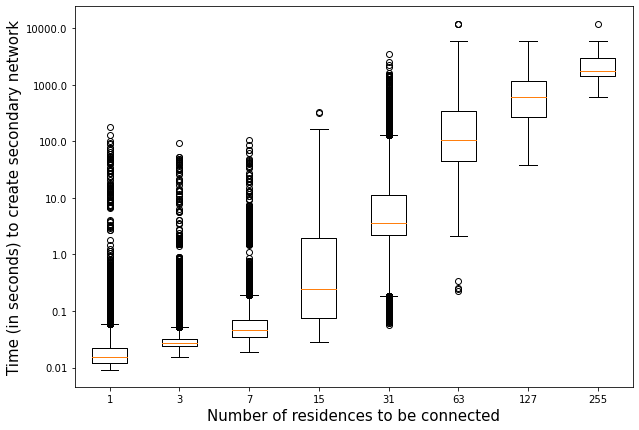

In [13]:
#%% Box Plot
xpts = [time[0] for time in time_stat]
ypts = [time[1] for time in time_stat]
_, xbins = np.histogram(np.log10(np.array(xpts)),bins=8)
ypts_dict = {'grp'+str(i+1):[np.log10(time[1]) for time in time_stat \
                             if 10**xbins[i]<=time[0]<=10**xbins[i+1]] \
             for i in range(len(xbins)-1)}

xmean = [int(round(10**((xbins[i]+xbins[i+1])/2))) for i in range(len(xbins)-1)]
xmean = [1,3,7,15,31,63,127,255]
ytick_old = np.linspace(-3,4,num=8)
ytick_new = 10**ytick_old

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.boxplot(ypts_dict.values())
ax.set_xticklabels(xmean)
ax.set_yticklabels(ytick_new)
ax.set_xlabel('Number of residences to be connected',fontsize=15)
ax.set_ylabel('Time (in seconds) to create secondary network',
              fontsize=15)
fig.savefig("{}{}.png".format(figpath,'secnet-time'),bbox_inches='tight')
